<a href="https://colab.research.google.com/github/skyshine460/Datascience_notebook/blob/main/LSTM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [30]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [31]:
import tensorflow as tf
import numpy as np
import random

# 再現性を確保するためにシードを設定
def set_random_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# 実行前にランダムシードを固定
set_random_seed(42)


In [32]:
df = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/train.csv")
test = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/test.csv")
sample_submit = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/sample_submit.csv", header=None)

In [33]:
# 事前に作成した特徴量データをインポート
merged_df = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/merged_df_2.csv")
df = merged_df.copy()

# データ処理

In [34]:
# 年度の初日をindex出力
dates = ["2011-04-01", "2012-04-01", "2013-04-01", "2014-04-01", "2015-04-01", "2016-03-31"]

for date in dates:
    print(f"{date}:", df[df["datetime"] == date].index)

2011-04-01: Index([90], dtype='int64')
2012-04-01: Index([456], dtype='int64')
2013-04-01: Index([821], dtype='int64')
2014-04-01: Index([1186], dtype='int64')
2015-04-01: Index([1551], dtype='int64')
2016-03-31: Index([1916], dtype='int64')


In [35]:
# 別で時系列を作成するので削除
df.drop(['seasonal', 'trend', 'residual', 'y_bc_1_2', 'y_lag_365'], axis=1, inplace=True)

# タイムステップ(秒単位)に変更
df['datetime'] = pd.to_datetime(df['datetime'])
df['timestamp_s'] = df['datetime'].apply(lambda x: x.timestamp())
df = df.drop(['datetime'], axis=1)

# 欠損値は一旦０に
df = df.fillna(0)

# データの分割
df = df[:-365]

In [36]:
# MinMaxScalerでスケーリング
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df)

df = pd.DataFrame(scaler.transform(df), columns=df.columns)

In [24]:
pd.set_option('display.max_columns', None)
df.describe()

,y,client,price_am,price_pm,client_mean,price_am_mean,price_pm_mean,is_train,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N,timestamp_s
count,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.0,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.0,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.0,1917.000000
mean,0.328485,0.107460,0.294992,0.254217,0.107460,0.476758,0.480656,0.0,0.294557,0.253869,0.292210,0.251608,0.288906,0.248392,0.286211,0.246827,0.270736,0.237524,0.252605,0.271280,0.458170,0.206502,0.229043,0.390597,0.428378,0.482620,0.490854,0.499913,0.475362,0.424883,0.285863,0.032864,0.032864,0.479047,0.010955,0.010955,0.003130,0.002608,0.0,0.504782,0.499635,0.018258,0.010433,0.017214,0.596332,0.423196,0.433356,0.344266,0.527264,0.374726,0.0,0.500000
std,0.158373,0.309777,0.176286,0.152495,0.309777,0.137017,0.135855,0.0,0.175573,0.151933,0.172156,0.147717,0.170655,0.144442,0.170143,0.143711,0.167689,0.140650,0.146620,0.179124,0.232762,0.129481,0.178499,0.242410,0.304161,0.318725,0.293352,0.333486,0.294825,0.317223,0.451943,0.178327,0.178327,0.378903,0.104117,0.104117,0.055872,0.051018,0.0,0.379452,0.341654,0.133917,0.101634,0.130103,0.269109,0.302296,0.363000,0.272371,0.203905,0.294894,0.0,0.288901
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.211009,0.000000,0.166667,0.166667,0.000000,0.384331,0.408097,0.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.162162,0.177778,0.340426,0.135135,0.139241,0.252252,0.200000,0.181818,0.233333,0.166667,0.211538,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.351047,0.136622,0.120567,0.107424,0.367316,0.200000,0.0,0.250000
50%,0.311927,0.000000,0.166667,0.166667,0.000000,0.384331,0.408097,0.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.216216,0.222222,0.382979,0.162162,0.177215,0.297297,0.400000,0.454545,0.500000,0.500000,0.461538,0.500000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.666667,0.400000,0.000000,0.000000,0.000000,0.622898,0.434535,0.264927,0.311980,0.541122,0.209677,0.0,0.500000
75%,0.422018,0.000000,0.333333,0.333333,0.000000,0.521391,0.566132,0.0,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.297297,0.288889,0.517730,0.216216,0.227848,0.450450,0.600000,0.727273,0.733333,0.833333,0.730769,0.750000,1.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.800000,0.000000,0.000000,0.000000,0.840560,0.679317

# データウインドウ

In [37]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, df, label_columns=None):
        # データフレームを設定
        self.df = df

        # ラベルとして使用するカラムが指定されている場合、それらのカラムのインデックスを取得
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        # 全カラムのインデックスを取得
        self.column_indices = {name: i for i, name in enumerate(df.columns)}

        # 入力とラベルの幅、シフト値を設定
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        # ウィンドウサイズ（入力データ幅 + シフト）
        self.total_window_size = input_width + shift

        # 入力の範囲（スライスオブジェクト）を作成
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        # ラベルの開始位置と範囲を設定（スライスオブジェクト）
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        # 入力とラベルを分割（時系列データの特定の範囲を切り出し）
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        # ラベルカラムが指定されている場合、指定されたカラムのみを抽出
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )

        # 入力とラベルの形状を設定（不定長次元の設定）
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='y', max_subplots=3):
        # サンプルバッチから入力データとラベルを取得
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        # 最大で指定された数のプロットを作成
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')

            # 入力データをプロット
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            # ラベルカラムのインデックスを取得
            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            # ラベルデータをプロット
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)

            # モデルが指定されている場合、予測結果をプロット
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        plt.show()  # プロットを表示

    def make_dataset(self, data):
        # データをnumpy配列に変換し、時系列データセットを作成
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,  # 入力データ
            targets=None,  # ターゲットなし（自分で分割）
            sequence_length=self.total_window_size,  # ウィンドウサイズ
            sequence_stride=1,  # ウィンドウをずらす幅
            shuffle=True,  # データをシャッフル
            batch_size=32  # バッチサイズ
        )

        # データセットを入力とラベルに分割するマッピング処理
        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def full_dataset(self):
        # 全体データ用のデータセットを作成
        return self.make_dataset(self.df)

    @property
    def sample_batch(self):
        # サンプルバッチを取得（初回アクセス時のみ生成）
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.full_dataset))  # 全体データからバッチを取得
            self._sample_batch = result
        return result

In [40]:
multi_window = DataWindow(input_width=365, label_width=1, shift=1, df=df, label_columns=['y'])

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber  # Huber損失関数をインポート
import tensorflow as tf
import numpy as np

# LSTMモデルを定義
def create_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=input_shape),
        Dense(1)  # 出力層。予測する値が1つの場合
    ])
    return model

# 'y'列を除いたデータを使う
input_features = df.drop(columns=['y']).values  # 特徴量のみ
input_shape = (365, input_features.shape[1])  # 365日分のデータと、特徴量の数
model = create_model(input_shape)

# モデルのコンパイルと訓練
def compile_and_fit(model, input_features, target_values, patience=3, max_epochs=50):
    # EarlyStoppingコールバックを定義
    early_stopping = EarlyStopping(monitor='loss', patience=patience, mode='min', restore_best_weights=True)

    # モデルをコンパイル
    model.compile(loss=Huber(), optimizer=Adam(), metrics=[MeanAbsoluteError()])

    # データをウィンドウに分割（365日分のデータを持つウィンドウを作成）
    input_data = []
    target_data = []

    for i in range(len(input_features) - 365):
        input_data.append(input_features[i:i + 365])  # 特徴量のみ
        target_data.append(target_values[i + 365])  # 'y'列のターゲット値

    input_data = np.array(input_data)
    target_data = np.array(target_data)

    # モデルの訓練実行
    history = model.fit(input_data, target_data, epochs=max_epochs, callbacks=[early_stopping], verbose=1)

    return history, input_data  # input_dataも返す

# 'y'列をターゲット値として取得
target_values = df['y'].values

# トレーニング実行
history, input_data = compile_and_fit(model, input_features, target_values)  # 特徴量とターゲット値を渡す

# df全体を使って予測を実行
predictions = model.predict(input_data)

# val_dfに対応する範囲の実績値を取得
val_df = df[1552:1917]  # 実際のデータ
val_actual = val_df['y'].values  # 実績値

# 予測値はモデルが予測した全体の予測からval_dfの範囲に該当する部分を抽出
val_predictions = predictions[1552 - 365:1917 - 365]  # 365日分のシフトを考慮

# MSEとMAEを計算
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.metrics.MeanAbsoluteError()

mse_result = mse(val_actual, val_predictions).numpy()
mae_result = mae(val_actual, val_predictions).numpy()

performance_mse = {}
performance_mae = {}

performance_mse['Baseline - LSTM'] = mse_result
performance_mae['Baseline - LSTM'] = mae_result

# 結果を表示
print(f"Validation MSE: {mse_result}")
print(f"Validation MAE: {mae_result}")


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - loss: 0.0127 - mean_absolute_error: 0.1252
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 0.0047 - mean_absolute_error: 0.0753
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - loss: 0.0037 - mean_absolute_error: 0.0655
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 0.0033 - mean_absolute_error: 0.0621
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - loss: 0.0031 - mean_absolute_error: 0.0597
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - loss: 0.0030 - mean_absolute_error: 0.0583
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - loss: 0.0029 - mean_absolute_error: 0.0573
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 0.0028 - mean_absolute_error: 0.0568
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0027 - mean_absolute_error: 0.0562
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - loss: 0.0026 - mean_absolute_error: 0.0557
Epoch 11/50
49/49 ━━━━━━

Validation MSE: 0.002903023734688759
Validation MAE: 0.04128985479474068

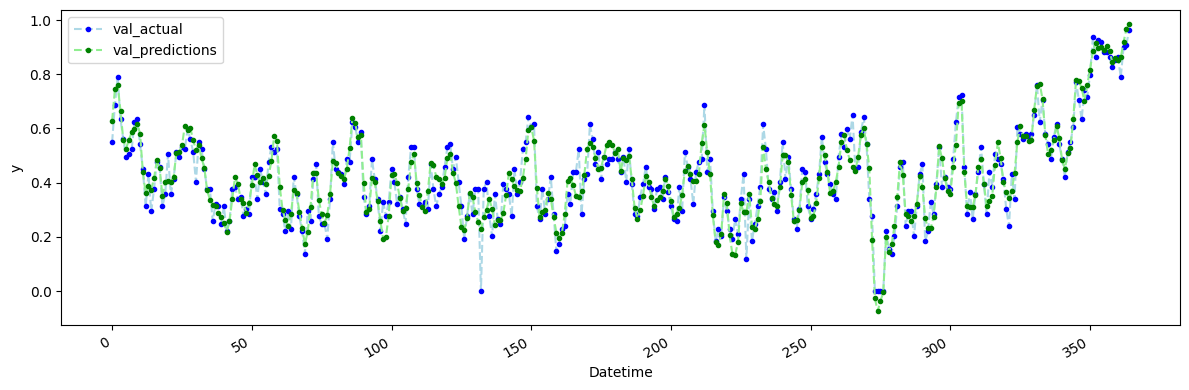

In [42]:
fig, ax = plt.subplots(figsize=(12, 4))


ax.plot(val_actual, ls='--', color='lightblue', label='val_actual', marker='o', markersize=3, markerfacecolor='blue', markeredgecolor='blue')
ax.plot(val_predictions, ls='--', color='lightgreen', label='val_predictions', marker='o', markersize=3, markerfacecolor='green', markeredgecolor='green')

ax.set_xlabel('Datetime')
ax.set_ylabel('y')

ax.legend(loc='best')
# plt.ylim(0, 140)

fig.autofmt_xdate()
plt.tight_layout()

In [43]:
# val_dfに対応する範囲の実績値を取得
val_df2 = df[1187:1552]  # 実際のデータ
val_actual = val_df2['y'].values  # 実績値

# 予測値はモデルが予測した全体の予測からval_dfの範囲に該当する部分を抽出
val_predictions2 = predictions[1187 - 365:1552 - 365]  # 365日分のシフトを考慮

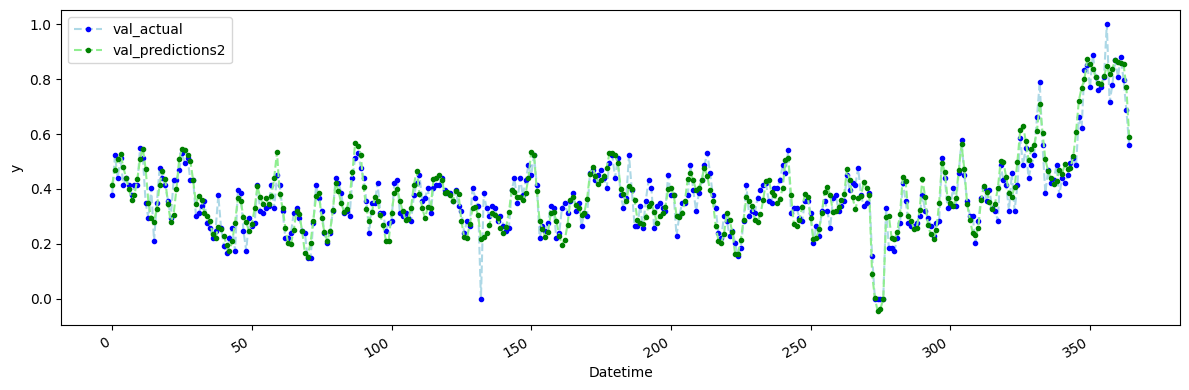

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))


ax.plot(val_actual, ls='--', color='lightblue', label='val_actual', marker='o', markersize=3, markerfacecolor='blue', markeredgecolor='blue')
ax.plot(val_predictions2, ls='--', color='lightgreen', label='val_predictions2', marker='o', markersize=3, markerfacecolor='green', markeredgecolor='green')

ax.set_xlabel('Datetime')
ax.set_ylabel('y')

ax.legend(loc='best')
# plt.ylim(0, 140)

fig.autofmt_xdate()
plt.tight_layout()